<a href="https://colab.research.google.com/github/prachi735/EVA5/blob/main/Session5/EVA5_S5_F4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils

# Transformations

In [ ]:
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-5.0, 5.0), fill=(1,)),
                                      # transforms.RandomAffine((-5.0,5.0),fillcolor=1),
                                       #transforms.RandomPerspective(),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       ])
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       ])

# Load dataset

In [ ]:
train = datasets.MNIST('./data', train=True, download=True,transform=train_transforms)
test = datasets.MNIST('./data', train=True, download=True,transform=test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Dataloaders: Test/Train dataset

In [ ]:
SEED = 3

# is cuda available
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)

# dataloader arguments
dataloader_args = dict(shuffle = True, batch_size = 128, num_workers = 4,pin_memory = True) if cuda else dict(shuffle = True, batch_size = 64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, ** dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics & Sample Data


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0, dtype=torch.uint8)
 - max: tensor(255, dtype=torch.uint8)
 - mean: 

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


tensor(33.3184)
 - std: tensor(78.5675)
 - var: tensor(6172.8506)
torch.Size([128, 1, 28, 28])
torch.Size([128])


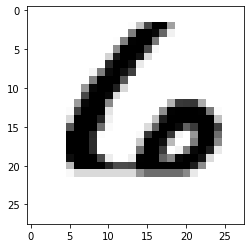

In [ ]:
# converting array into numpy from tensor
train_data = train.train_data
#train_data = train.transform(train.train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.Tensor.float(train_data).mean())
print(' - std:', torch.Tensor.float(train_data).std())
print(' - var:', torch.Tensor.float(train_data).var())

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[52].numpy().squeeze(), cmap='gray_r')


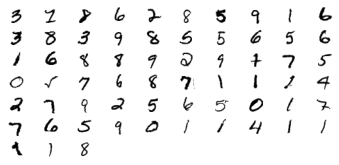

In [ ]:
figure = plt.figure()
num_of_images = 63
for index in range(1, num_of_images + 1):
    plt.subplot(10, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

## Data properties

In [ ]:
# simple transform
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                        transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)


# Basic Model

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10)
        ) # input_size = 28 output_size = 26 receptive_field = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10)
        ) # input_size = 26 output_size = 24 receptive_field = 5

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        ) # input_size = 12 output_size = 10 receptive_field = 5

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10)
        ) # input_size = 12 output_size = 10 receptive_field = 5


        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # input_size = 24 output_size = 12 receptive_field = 

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10)
        ) # input_size = 5 output_size = 3 receptive_field = 13

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        ) # input_size = 5 output_size = 3 receptive_field = 13

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        ) # input_size = 5 output_size = 3 receptive_field = 13

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10)
        ) # input_size = 5 output_size = 3 receptive_field = 13

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10)
        ) # input_size = 5 output_size = 3 receptive_field = 13

        # OUTPUT BLOCK
        self.convblock10 = nn.Sequential(
            nn.AdaptiveMaxPool2d((1,1)),
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # input_size = 5 output_size = 1  receptive_field = 29
        

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.pool1(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)   
        
    

# Model Params

In [ ]:
!pip install torchsummary
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1,28,28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
            Conv2d-4           [-1, 10, 24, 24]             900
              ReLU-5           [-1, 10, 24, 24]               0
       BatchNorm2d-6           [-1, 10, 24, 24]              20
            Conv2d-7           [-1, 16, 22, 22]           1,440
              ReLU-8           [-1, 16, 22, 22]               0
       BatchNorm2d-9           [-1, 16, 22, 22]              32
           Conv2d-10           [-1, 10, 22, 22]             160
             ReLU-11           [-1, 10, 22, 22]               0
      BatchNorm2d-12           [-1, 10, 22, 22]              20
        MaxPool2d-13           [-1, 10, 11, 11]               0
           Conv2d-14             [

In [ ]:
print(model)

Net(
  (convblock1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (convblock2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (convblock3): Sequential(
    (0): Conv2d(10, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (convblock4): Sequential(
    (0): Conv2d(16, 10, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (convblock5): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride

#Training & Testing

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Train & Test model

In [ ]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr= 0.01, momentum=0.9)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_loader, optimizer,epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 1


Loss=0.10705684870481491 Batch_id=468 Accuracy=91.78: 100%|██████████| 469/469 [00:16<00:00, 29.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0876, Accuracy: 58421/60000 (97.37%)

EPOCH: 2


Loss=0.10388976335525513 Batch_id=468 Accuracy=97.87: 100%|██████████| 469/469 [00:15<00:00, 29.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0523, Accuracy: 59093/60000 (98.49%)

EPOCH: 3


Loss=0.02254108525812626 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:16<00:00, 29.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0425, Accuracy: 59240/60000 (98.73%)

EPOCH: 4


Loss=0.04290330037474632 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:15<00:00, 29.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0366, Accuracy: 59333/60000 (98.89%)

EPOCH: 5


Loss=0.04929729178547859 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:15<00:00, 29.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0280, Accuracy: 59513/60000 (99.19%)

EPOCH: 6


Loss=0.020036423578858376 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:16<00:00, 28.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0330, Accuracy: 59384/60000 (98.97%)

EPOCH: 7


Loss=0.023763427510857582 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:15<00:00, 29.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 59545/60000 (99.24%)

EPOCH: 8


Loss=0.023179933428764343 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:15<00:00, 29.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 59639/60000 (99.40%)

EPOCH: 9


Loss=0.02784227579832077 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:16<00:00, 28.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 59583/60000 (99.31%)

EPOCH: 10


Loss=0.03142548352479935 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:15<00:00, 29.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0154, Accuracy: 59724/60000 (99.54%)

EPOCH: 11


Loss=0.04053254798054695 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:15<00:00, 29.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0167, Accuracy: 59696/60000 (99.49%)

EPOCH: 12


Loss=0.0022288786713033915 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:15<00:00, 29.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0158, Accuracy: 59715/60000 (99.53%)

EPOCH: 13


Loss=0.03549889102578163 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:16<00:00, 28.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0137, Accuracy: 59744/60000 (99.57%)

EPOCH: 14


Loss=0.028850076720118523 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:15<00:00, 29.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0158, Accuracy: 59699/60000 (99.50%)

EPOCH: 15


Loss=0.02076966129243374 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:16<00:00, 28.40it/s]



Test set: Average loss: 0.0160, Accuracy: 59692/60000 (99.49%)



# Ploting model result

Text(0.5, 1.0, 'Test Accuracy')

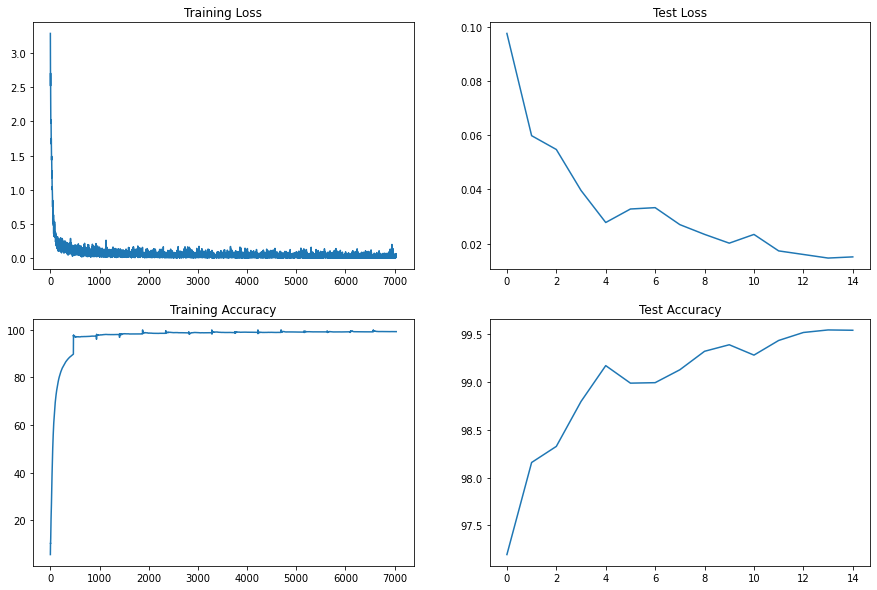

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")